In [4]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_forward, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_rc)
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123

sns.set()
sns.set_style("white")

device = 'cpu'
data_path = '../../data/rc_circuit'


    
dt = 0.5 # Sampling interval used for simulation
fs =( 1/dt) * 1e3
tstop = 350

/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


In [5]:
prior_dict = {'amp1': {'bounds': (0, 1), 'scale_func': linear_scale_forward},
              'amp2': {'bounds': (0, 1), 'scale_func': linear_scale_forward}, 
              'latency': {'bounds': (-75, 75), 'scale_func': linear_scale_forward}}

In [6]:
simulator = partial(simulator_rc, prior_dict=prior_dict, tstop=350)

In [8]:
theta_cond_list = [np.array([0.3, 0.5, 0.5]), np.array([0.3, 0.5, 0.75])]

x_cond_list, theta_dict_list = list(), list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['scale_func'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    x_cond = simulator(torch.tensor(theta_cond).float())
    
    theta_dict_list.append(theta_dict)
    x_cond_list.append(x_cond.T)


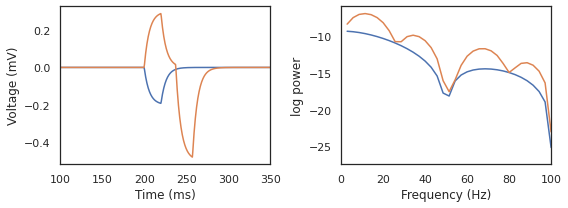

In [9]:
%matplotlib inline
x_cond_psd0, f = get_dataset_psd(x_cond_list[0], fs)
x_cond_psd1, _ = get_dataset_psd(x_cond_list[1], fs)

t_vec = np.linspace(0, tstop, x_cond_list[0].squeeze().shape[0])
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(t_vec, x_cond_list[0].squeeze())
plt.plot(t_vec, x_cond_list[1].squeeze())
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim([100,350])

plt.subplot(1,2,2)
plt.plot(f, x_cond_psd0.squeeze())
plt.plot(f, x_cond_psd1.squeeze())
plt.xlabel('Frequency (Hz)')
plt.ylabel('log power')
plt.xlim([0,100])

plt.tight_layout()

In [30]:
import scipy

def bandpower(x, fs, fmin, fmax):
    f, Pxx = scipy.signal.periodogram(x, fs=fs)
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

# Bands freq citation: https://www.frontiersin.org/articles/10.3389/fnhum.2020.00089/full
def get_dataset_bandpower(x, fs):
    freq_band_list = [(8,13), (13,30), (30,50), (50,80)]
    
    x_bandpower_list = list()
    for idx in range(x.shape[0]):
        x_bandpower = np.array([bandpower(x[idx,:], fs, freq_band[0], freq_band[1]) for freq_band in freq_band_list])
        x_bandpower_list.append(x_bandpower)
        
    return np.vstack(np.log(x_bandpower_list))

In [31]:
get_dataset_bandpower(np.array(x_cond_list).squeeze(), fs)

array([[ -8.39387614,  -7.48534039,  -9.54717087, -11.53381154],
       [ -6.18083761,  -5.02342636,  -7.55215552,  -9.16604292]])